# Reads Assignment - FUCCI

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from starmap.sequencing import *
from natsort import natsorted
from scipy.io import loadmat, savemat
from skimage.filters import threshold_otsu
from skimage.color import label2rgb

In [2]:
from tqdm.notebook import tqdm

### Functions

In [3]:
from functools import wraps
from time import time

# Timer
def timer(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(time() * 1000)) - start
            end_ = round(end_ / 1000, 4)
            print(f"Total execution time: {end_ if end_ > 0 else 0} s")
    return _time_it


@timer
# Load reads and their positions from mat file
def load_reads(fpath, reads_file):
    S = loadmat(os.path.join(fpath, reads_file))
    bases = [str(i[0][0]) for i in S["merged_reads"]]
    points = S["merged_points"]
    temp = np.zeros(points.shape)
    temp[:, 0] = np.round(points[:, 1]-1)
    temp[:, 1] = np.round(points[:, 0]-1)
    temp[:, 2] = np.round(points[:, 2]-1)
    
    print(f"Number of reads: {len(bases)}")
    
    return bases, temp


# Load gene table from genes.csv
def load_genes(fpath):
    genes2seq = {}
    seq2genes = {}
    with open(os.path.join(fpath, "genes.csv"), encoding='utf-8-sig') as f:
        for l in f:
            fields = l.rstrip().split(",")
            genes2seq[fields[0]] = "".join([str(s+1) for s in encode_SOLID(fields[1][::-1])])
            seq2genes[genes2seq[fields[0]]] = fields[0]
    return genes2seq, seq2genes

## Input

In [4]:
# IO path 
# base_path = './'
input_path = 'Z:/Data/Analyzed/2022-02-02-Hu-Hela_FUCCI/'

out_path = os.path.join(input_path, 'output')
if not os.path.exists(out_path):
    os.mkdir(out_path)

## Run pipeline for individual sample

In [5]:
current_sample = 'ribomap'
print(f"Current sample: {current_sample}")

# Load genes
genes2seqs, seqs2genes = load_genes(input_path)

# Load reads 
bases, points = load_reads(os.path.join(input_path, 'merged_spots', current_sample), "merged_goodPoints_max3d.mat")
bases = np.array([seqs2genes[x] for x in bases])
points = np.array(points)

Current sample: ribomap
Number of reads: 3107821
Total execution time: 21.342 s


====Processing: whole_cell====
Total number of cells: 1949
Getting region information...


  0%|          | 0/1949 [00:00<?, ?it/s]

Iterate cells...


  0%|          | 0/1949 [00:00<?, ?it/s]

94.56% percent [2938866.0 out of 3107821] reads were assigned to 1949 cells


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


====Processing: nucleus====
Getting region information...


  0%|          | 0/1949 [00:00<?, ?it/s]

Iterate cells...


  0%|          | 0/1949 [00:00<?, ?it/s]

12.03% percent [373791.0 out of 3107821] reads were assigned to 1949 cells


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


====Processing: cytoplasm====
Getting region information...


  0%|          | 0/1949 [00:00<?, ?it/s]

Iterate cells...


  0%|          | 0/1949 [00:00<?, ?it/s]

82.54% percent [2565075.0 out of 3107821] reads were assigned to 1949 cells


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


====Processing: outer_cytoplasm====
Getting region information...


  0%|          | 0/1949 [00:00<?, ?it/s]

Iterate cells...


  0%|          | 0/1949 [00:00<?, ?it/s]

25.97% percent [807156.0 out of 3107821] reads were assigned to 1949 cells


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


====Processing: er====
Getting region information...


  0%|          | 0/1949 [00:00<?, ?it/s]

Iterate cells...


  0%|          | 0/1949 [00:00<?, ?it/s]

56.57% percent [1758037.0 out of 3107821] reads were assigned to 1949 cells


C:\Users\jiahao\.conda\envs\bio38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


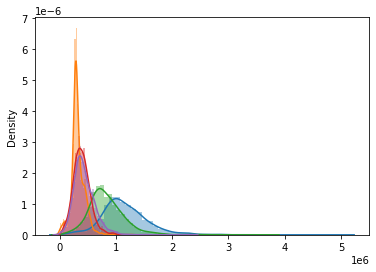

In [6]:
structure_dict = {'whole_cell': 'cell.tif',
                 'nucleus': 'nuclei.tif',
                 'cytoplasm': 'cyto.tif',
                 'outer_cytoplasm': 'outer_cyto.tif',
                 'er': 'er.tif'}

total_cells = None

expr_out_path = os.path.join(out_path, current_sample)
if not os.path.exists(expr_out_path):
    os.mkdir(expr_out_path)
        
expr_dict = {}
for current_structure in structure_dict.keys():
    print(f"====Processing: {current_structure}====")
    # Path
    seg_path = os.path.join(input_path, 'segmentation', current_sample)
    img_path = os.path.join(input_path, 'images', current_sample)

    # Load segmentation
    current_seg = load_label_image(seg_path, fname=structure_dict[current_structure])

    # # Load fluro image
    # fluro_ch01 = load_label_image(img_path, fname='fluro_ch01.tif')
    # fluro_ch02 = load_label_image(img_path, fname='fluro_ch02.tif')
    
#     if current_structure == 'whole_cell':
        
#         # Load image
#         current_img = load_label_image(seg_path, fname='overlay_label.tiff')

#         # Set figsize
#         figsize = (np.floor(current_img.shape[1] / 1000 * 5), np.floor(current_img.shape[0] / 1000 * 5))

#         # Plot cell number 
#         t_size = 10
#         plt.figure(figsize=figsize)
#         plt.imshow(current_img > 0, cmap='Greys')
#         for i, region in enumerate(regionprops(current_seg)):
#             plt.plot(region.centroid[1], region.centroid[0], '.', color='red', markersize=4)
#             plt.text(region.centroid[1], region.centroid[0], str(region.label - 1), fontsize=t_size, color='red')
#         plt.axis('off')
#         plt.savefig(os.path.join(seg_path, f"cell_nums_{current_structure}.png"))
#         plt.clf()
#         plt.close()
    
#         # Plot dots on segmentation mask
#         plt.figure(figsize=figsize)
#         plt.imshow(current_img > 0, cmap='gray')
#         plt.plot(points[:, 1], points[:, 0], '.', color='red', markersize=1)
#         plt.axis('off')
#         print(f"Saving points_seg.png")
#         plt.savefig(os.path.join(seg_path, f"points_seg_{current_structure}.png"))
#         plt.clf()
#         plt.close()
    
    
    # Reads assignment to current_structure
    current_out_path = os.path.join(expr_out_path, current_structure)
    if not os.path.exists(current_out_path):
        os.mkdir(current_out_path)

    points = points.astype(int)
    reads_assignment = current_seg[points[:, 2], points[:, 0], points[:, 1]]

    if not total_cells:
        total_cells = len(np.unique(current_seg)) - 1
        print(f"Total number of cells: {total_cells}")

    genes = genes2seqs.keys()
    cell_by_barcode = np.zeros((total_cells, len(genes)))
    genes_to_index = {}  # map from sequence to index into matrix

    for i, k in enumerate(genes):
        genes_to_index[k] = i
        
    # Get region information 
    print('Getting region information...')
    region_labels = []
    areas_dict = []
    cell_locs_dict = []
    for i, region in enumerate(tqdm(regionprops(current_seg))):
        # print(region.label)
        region_labels.append(region.label)
        areas_dict.append(region.area)
        cell_locs_dict.append(region.centroid)
        
#         areas_dict[region.label] = region.area
#         cell_locs_dict[region.label] = region.centroid
    
    # Iterate through cells
    print('Iterate cells...')
    areas = []
    cell_locs = []
    for i in tqdm(range(total_cells)):
        current_label = i+1
        if current_label in region_labels:
            areas.append(areas_dict[region_labels.index(current_label)])
            cell_locs.append(cell_locs_dict[region_labels.index(current_label)])
        else:
            areas.append(0)
            cell_locs.append([0, 0, 0])
            
        assigned_reads = bases[np.argwhere(reads_assignment == current_label).flatten()]
        for j in assigned_reads:
            if j in genes_to_index:
                cell_by_barcode[i, genes_to_index[j]] += 1

    cell_locs = np.array(cell_locs).astype(int)
    curr_meta = pd.DataFrame({'sample': 'STARmap', 'area': areas,
                              'x':cell_locs[:, 1], 'y':cell_locs[:, 2], 'z':cell_locs[:, 0]})

    # Output
    with open(os.path.join(current_out_path, "log.txt"), 'w') as f:
        msg = "{:.2%} percent [{} out of {}] reads were assigned to {} cells".format(cell_by_barcode.sum()/len(bases), cell_by_barcode.sum(), len(bases), total_cells)
        print(msg)
        f.write(msg)
    np.savetxt(os.path.join(current_out_path, "cell_barcode_count.csv"), cell_by_barcode.astype(np.int), delimiter=',', fmt="%d")
    cell_barcode_names = pd.DataFrame({'seq': list(seqs2genes.keys()), 'gene': list(seqs2genes.values())})
    cell_barcode_names.to_csv(os.path.join(current_out_path, "cell_barcode_names.csv"), header=False)
    curr_meta.to_csv(os.path.join(current_out_path, "meta.csv"))

    expr_dict[current_structure] = cell_by_barcode
    # print(curr_meta.head())
    sns.distplot(areas)

## Generate complete matrix for all samples

In [8]:
# Construct complete matrix
sample_dirs = ['ribomap', 'starmap']
for current_structure in structure_dict.keys():
    print(f"====Generating: {current_structure}====")
    cell_by_gene_complete = None
    meta_complete = None
    for i, d in enumerate(sample_dirs):
        print(f"Loading sample: {d}")
        current_expr_path = os.path.join(out_path, d, current_structure)
        current_expr = np.loadtxt(os.path.join(current_expr_path, "cell_barcode_count.csv"), dtype=int, delimiter=',')
        current_meta = pd.read_csv(os.path.join(current_expr_path, "meta.csv"))

        # add to complete matrix
        if cell_by_gene_complete is not None:
            cell_by_gene_complete = np.concatenate((cell_by_gene_complete, current_expr))
        else:
            cell_by_gene_complete = current_expr

        if meta_complete is not None:
            meta_complete = pd.concat([meta_complete, current_meta])
        else:
            meta_complete = current_meta

    current_output_path = os.path.join(out_path, current_structure)
    if not os.path.exists(current_output_path):
        os.mkdir(current_output_path)
    np.savetxt(os.path.join(current_output_path, "complete_cell_barcode_count.csv"), cell_by_gene_complete.astype(np.int), delimiter=',', fmt="%d")
    meta_complete = meta_complete.reset_index(drop=True)
    meta_complete = meta_complete.rename(columns={"Unnamed: 0": "orig_index"})
    meta_complete.to_csv(os.path.join(current_output_path, "complete_meta.csv"))
    cell_barcode_names.to_csv(os.path.join(current_output_path, "cell_barcode_names.csv"), header=False)

====Generating: whole_cell====
Loading sample: ribomap
Loading sample: starmap
====Generating: nucleus====
Loading sample: ribomap
Loading sample: starmap
====Generating: cytoplasm====
Loading sample: ribomap
Loading sample: starmap
====Generating: outer_cytoplasm====
Loading sample: ribomap
Loading sample: starmap
====Generating: er====
Loading sample: ribomap
Loading sample: starmap
